In [1]:
import sys
sys.path.append('..')

from tools.siren import *
from tools.table import *

from functools import partial

from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
table = Table('cprof_mu_train_10000ev.h5')

ene_bins = table.normalize(0, table.binning[0])
cos_bins = table.normalize(1, np.linspace(min(table.binning[1]), max(table.binning[1]), 200))
trk_bins = table.normalize(2, np.linspace(min(table.binning[2]), max(table.binning[2]), 200))

cos_trk_mesh = np.array([[x,y] for x in cos_bins for y in trk_bins])
linear_interpolator = interpolate.interp1d(table.binning[0], ene_bins, kind='linear')
grid_shape = (table.binning[1].shape[0]*table.binning[2].shape[0],3)

siren_light_profile, siren_params = load_siren_jax('siren_cprof_mu.pkl')

In [3]:
from scipy import stats

energies = [300, 400, 500, 600, 700, 800, 900]

def integrand(points):
    value, _ = siren_light_profile.apply(siren_params, points)
    return value

integ_phot = []
integ_phot_err = []
def monte_carlo_integrate(energy, n_samples=1000000):
    x_min, x_max = min(cos_bins), max(cos_bins)
    y_min, y_max = min(trk_bins), max(trk_bins)
    
    # Generate random points in the integration domain
    x_samples = stats.uniform.rvs(x_min, x_max - x_min, size=n_samples)
    y_samples = stats.uniform.rvs(y_min, y_max - y_min, size=n_samples)

    points = jnp.array(np.array([[linear_interpolator(energy), x, y] for x, y in zip(x_samples, y_samples)]))
    values = integrand(points)

    # Calculate integral and error estimate
    area = (x_max - x_min) * (y_max - y_min)
    result = area * np.mean(values)
    error = area * np.std(values) / np.sqrt(n_samples)
    
    return result, error

# Use it in the main loop
for energy in energies:
    result, err = monte_carlo_integrate(energy)
    integ_phot.append(result)
    integ_phot_err.append(err)
    print(f"Energy {energy}: Integral = {result:.4f} (error estimate: {err:.4f})")

Energy 300: Integral = 0.0080 (error estimate: 0.0001)
Energy 400: Integral = 0.0134 (error estimate: 0.0001)
Energy 500: Integral = 0.0194 (error estimate: 0.0002)
Energy 600: Integral = 0.0258 (error estimate: 0.0002)
Energy 700: Integral = 0.0321 (error estimate: 0.0002)
Energy 800: Integral = 0.0392 (error estimate: 0.0003)
Energy 900: Integral = 0.0452 (error estimate: 0.0003)


In [4]:
delta_X = table.binning[0][-1]-table.binning[0][0]
delta_Y = table.binning[1][-1]-table.binning[1][0]
delta_Z = table.binning[2][-1]-table.binning[2][0]

delta_X, delta_Y, delta_Z

1e4*(delta_Y*delta_Z)

11949274.267137123

In [5]:
from tools.generate import new_differentiable_get_rays
from tools.simulation import create_siren_grid

table_data = create_siren_grid(table)

origin = jnp.array([0.5, 0.0, -0.5])
direction = jnp.array([1.0, -1.0, 0.2])
Nphot = 3_000_000
key = random.PRNGKey(0)

sum_phot_w = []
for i, energy in enumerate(energies):

    ray_vectors, ray_origins, photon_weights = new_differentiable_get_rays(origin, direction, energy, Nphot, table_data, siren_params, key)
    sum_phot_w.append(np.sum(photon_weights))


array([ 6.27759495e-05, -1.14906746e-02])

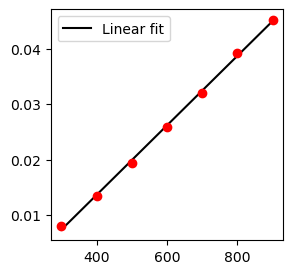

In [6]:
import numpy as np

# Create the linear fit
fig, axes = plt.subplots(1,1, figsize=(3,3))
coefficients = np.polyfit(energies,  np.array(integ_phot), 1)  # 1 indicates linear fit
fit_line = np.poly1d(coefficients)

plt.plot(energies, fit_line(energies), '-k', label=f'Linear fit')
plt.scatter(energies, integ_phot, color='r', zorder=4)
plt.legend()

coefficients

In [7]:
import numpy as np

siren_inverse_norm = 1e4*(delta_Y*delta_Z)
siren_integral_from_fit = np.array([x*coefficients[0]+coefficients[1] for x in energies])

siren_inverse_norm*siren_integral_from_fit

array([ 87732.88873833, 162745.59251221, 237758.2962861 , 312771.00005999,
       387783.70383387, 462796.40760776, 537809.11138165])

### this seems unphysically large! by a factor ~5

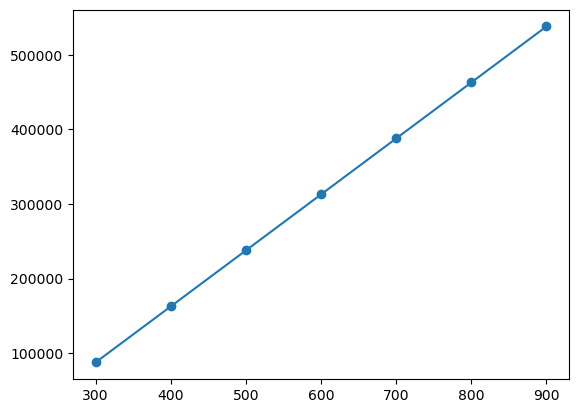

In [8]:
plt.scatter(energies, siren_inverse_norm*siren_integral_from_fit)
plt.plot(energies, siren_inverse_norm*siren_integral_from_fit)